In [75]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adadelta
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

def load_data(verbose = True):
    X_train, Y_train = tfds.as_numpy(tfds.load('mnist', split='train', batch_size=-1, as_supervised=True))
    X_test, Y_test = tfds.as_numpy(tfds.load('mnist', split='test', batch_size=-1, as_supervised=True))
    
    if verbose:
        print(f'train data: {X_train.shape}')
        print(f'train label: {Y_train.shape}')
        print(f'test data: {X_test.shape}')
        print(f'test label: {Y_test.shape}')
    
    return X_train, Y_train, X_test, Y_test
    
def prepare_data(X_train, Y_train, X_test, Y_test):
    Y_train, Y_test = list(map(to_categorical, [Y_train, Y_test]))
    X_train = X_train.astype('float32')/255.0
    X_test = X_test.astype('float32')/255.0
    return X_train, Y_train, X_test, Y_test

def summarize_diagnostics(history):
	plt.figure(figsize=(15, 5))
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')
	plt.show()

	plt.figure(figsize=(15, 5))
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')
	plt.show()

def save(model, name):
    model_json = model.to_json()
    with open(f"{name}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{name}.h5")

In [76]:
def define_model():
    inputs = keras.Input(shape=(28, 28, 1))
    lay_1 = Conv2D(20, kernel_size=(4, 4), activation='relu', kernel_initializer='he_uniform')(inputs)
    lay_2 = MaxPooling2D(pool_size=(2, 2))(lay_1)
    lay_3 = Conv2D(40, kernel_size=(5, 5), activation='relu', kernel_initializer='he_uniform')(lay_2)
    lay_4 = MaxPooling2D(pool_size=(3, 3))(lay_3)
    flatt = Flatten()(lay_4)
    lay_5 = Dense(150, activation='relu', kernel_initializer='he_uniform')(flatt)
    outputs = Dense(10, activation='softmax')(lay_5)
    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

    opt = SGD()
    model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])
    return model

In [79]:
def learning(epochs=80, batch_size=25, name='model'):
    lr_sched = LearningRateScheduler(lambda epoch: 0.05 * (0.995/(epoch+1)))
    earlystopping=[EarlyStopping(monitor='loss', patience=5, verbose=1, mode='auto')]
    X_train, Y_train, X_test, Y_test = load_data(verbose=0)
    X_train, Y_train, X_test, Y_test = prepare_data(X_train, Y_train, X_test, Y_test)
    model = define_model()

    history = model.fit(X_train, Y_train, epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.1, 
                        verbose=True, 
                        callbacks=[lr_sched, earlystopping]
                        )

    score = model.evaluate(X_test, Y_test, verbose=0)
    
    summarize_diagnostics(history)
    print( f'Loss on test data: {score[0]:.4f}')
    print( f'Accuracy on test data: {score[1]:.4f}')

    save(model, name)
    return model


Epoch 1/30
2160/2160 [==============================] - 18s 8ms/step - loss: 0.3067 - accuracy: 0.9064 - val_loss: 0.1544 - val_accuracy: 0.9560
Epoch 2/30
2160/2160 [==============================] - 18s 8ms/step - loss: 0.1223 - accuracy: 0.9617 - val_loss: 0.1058 - val_accuracy: 0.9697
Epoch 3/30
2160/2160 [==============================] - 17s 8ms/step - loss: 0.0950 - accuracy: 0.9707 - val_loss: 0.0933 - val_accuracy: 0.9735
Epoch 4/30
2160/2160 [==============================] - 18s 8ms/step - loss: 0.0798 - accuracy: 0.9742 - val_loss: 0.0855 - val_accuracy: 0.9760
Epoch 5/30
2160/2160 [==============================] - 18s 8ms/step - loss: 0.0691 - accuracy: 0.9788 - val_loss: 0.0756 - val_accuracy: 0.9782
Epoch 6/30
2160/2160 [==============================] - 18s 8ms/step - loss: 0.0626 - accuracy: 0.9807 - val_loss: 0.0738 - val_accuracy: 0.9795
Epoch 7/30
2160/2160 [==============================] - 18s 8ms/step - loss: 0.0561 - accuracy: 0.9828 - val_loss: 0.0751 - val_ac

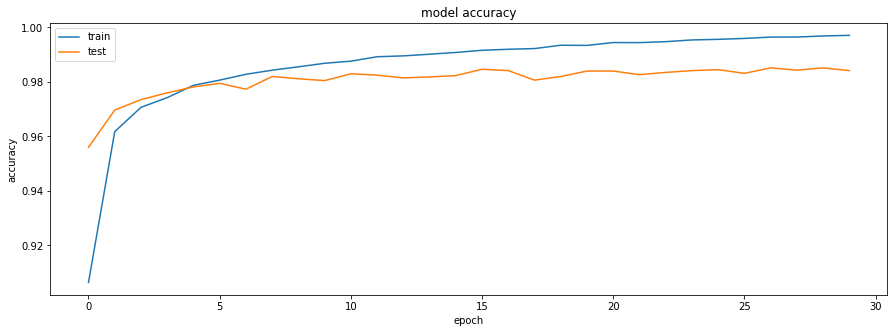

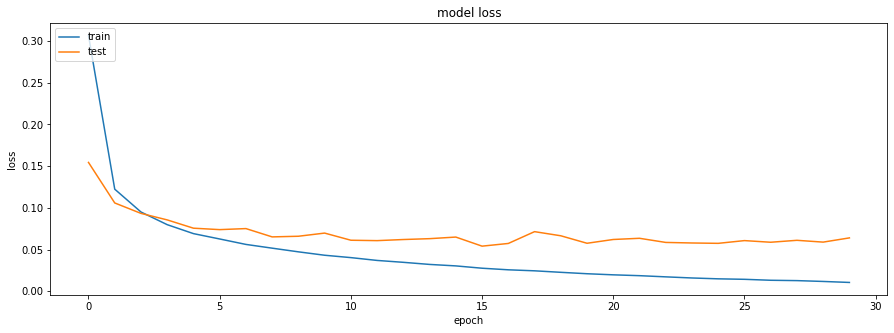

Loss on test data: 0.0514
Accuracy on test data: 0.9858


In [80]:
model = learning(epochs=30, name='model')